In [1]:
import bempp.api
import os
import numpy as np
import time
from login import gmres, get_h
from operators import PMCHWT_operator, PMCHWT_preconditioner, mass_matrix_BC_SNC
bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
from IPython import embed
from multiprocessing import Pool
import multiprocessing

In [2]:
bempp.api.__version__

'3.3.5'

In [3]:
frequency = 657.3E9 #pick a frequency from 50, 183, 243 and 664 GHz
temperature = 190 #pick a temperature from 190, 210, 230, 250, 270 
wavelength = (3E8/frequency) 
k_ext = 2 *np.pi/wavelength

if frequency == 50E9:
    if temperature == 190:
        r = 1.7643 + 0.00042j
    elif temperature == 210:
        r = 1.7695 + 0.00051j
    elif temperature == 230:
        r = 1.7746 + 0.00064j
    elif temperature == 250:
        r = 1.7797 + 0.00084j
    elif temperature == 270:
        r = 1.7848 + 0.00120j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 183E9:
    if temperature == 190:
        r = 1.7643 + 0.00154j
    elif temperature == 210:
        r = 1.7695 + 0.00188j
    elif temperature == 230:
        r = 1.7746 + 0.00235j
    elif temperature == 250:
        r = 1.7797 + 0.00309j
    elif temperature == 270:
        r = 1.7849 + 0.00442j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 243E9:
    if temperature == 190:
        r = 1.7643 + 0.00207j
    elif temperature == 210:
        r = 1.7695 + 0.00252j
    elif temperature == 230:
        r = 1.7746 + 0.00314j
    elif temperature == 250:
        r = 1.7795 + 0.00412j
    elif temperature == 270:
        r = 1.7849 + 0.00589j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 664E9:
    if temperature == 190:
        r = 1.7643 + 0.00649j
    elif temperature == 200:
        r = 1.7669+ 0.00706j
    elif temperature == 210:
        r = 1.7695 + 0.00771j
    elif temperature == 230:
        r = 1.7746 + 0.00940j
    elif temperature == 250:
        r = 1.7798 + 0.01209j
    elif temperature == 270:
        r = 1.7849 + 0.01690j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 657.3E9:
    if temperature == 190:
        r = 1.7643 + 0.00640j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
else: raise ValueError('Frequency {0}GHz not available'.format(frequency * 1E-9))
    

In [4]:
size = '1,936mm' #choose from 2mm,4mm or 8mm
refinement_level = '20elements' # choose from 10elements, 15elements or 20elements
path_to_aggregate = os.getcwd() + '/aggregate/' + size + '/' + refinement_level #+'-version2'
number_of_scatterers = int(len(os.listdir(path_to_aggregate))/2)
print('Number of scatterers: {0}'.format(number_of_scatterers))

grids = []
for i in range(number_of_scatterers):
    rosette = bempp.api.import_grid(path_to_aggregate + '/hex' + str(i) + '.msh')
    grids.append(rosette)

Nelements = np.sum([np.shape(grid.leaf_view.elements)[1] for grid in grids])
print('Number of elements: {0}'.format(Nelements))

Number of scatterers: 8
Number of elements: 34284


In [5]:
processes = multiprocessing.cpu_count()
print('processors: {0}'.format(processes))

processors: 96


In [6]:
n_ind = [r] * number_of_scatterers
k_int = [k_ext * i for i in n_ind]

mu_ext = 1.0
mu_int = [1.0] * number_of_scatterers

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


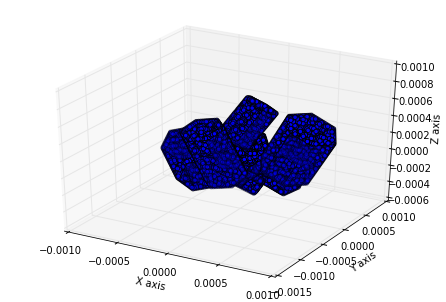

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    grid = grids[i]
    vertices = grid.leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

In [8]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,1]
quad_nu= [4,3,2,6]
# quad_nu = [8,8,8,8]
mu = 0.1
nu = 0.001
nf = 1

################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
################################################
# Parameters mu near field

parameters_mu_nf = global_parameters()
if mu == -1:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='hmat'
parameters_mu_nf.hmat.eps = mu
parameters_mu_nf.quadrature.double_singular = quad_mu[3]
parameters_mu_nf.quadrature.far.double_order = quad_mu[2]
parameters_mu_nf.quadrature.medium.double_order = quad_mu[1]
parameters_mu_nf.quadrature.near.double_order = quad_mu[0]
parameters_mu_nf.hmat.cutoff = nf

In [9]:
# Set spaces
rwg_space = [bempp.api.function_space(grid, 'RWG', 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, 'SNC', 0) for grid in grids]
bc_space = [bempp.api.function_space(grid, 'BC', 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, 'RBC', 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

[PMCHWT_op, filter_operators] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu)
PMCHWT_pre = PMCHWT_preconditioner(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_mu_nf)
mass_matrix = mass_matrix_BC_SNC(grids)

t0 = time.time()
pre_sf = PMCHWT_pre.strong_form()
op_wf = PMCHWT_op.weak_form()
cald_op_sf = pre_sf * mass_matrix * op_wf
ta_cald_op_sf = time.time() - t0
print('assembly time: {0} mins'.format(ta_cald_op_sf/60))

assembly time: 7.6431769490242 mins


In [10]:
restart = 1000
maxiter = 1000
tol=1E-5

In [11]:
n_averaging = 25 #for a list of available point see files in PointDistFiles/lebedev
if n_averaging <10:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_00{0}.txt'.format(n_averaging))
else:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_averaging))
w_averaging = coord[:,2] #weights
n_waves = np.shape(w_averaging)[0]
print('Number of waves: {0}'.format(np.shape(w_averaging)[0]))
phi_averaging = np.radians(coord[:,0]) #phi
theta_averaging = np.radians(coord[:,1])#theta

Number of waves: 230


In [12]:
number_of_angles = 1801

n_leb = 59
coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_leb))
w_leb = coord[:,2] #weights
phi_leb = np.radians(coord[:,0]) #phi
theta_leb = np.radians(coord[:,1])#theta


In [13]:
N_gauss = 15
[angles_gauss, weights_gamma] = np.polynomial.legendre.leggauss(N_gauss)
weights_gamma = weights_gamma/2
angles_gauss = (2*np.pi)*angles_gauss/2 + (2*np.pi)/2

In [14]:
def incident_wave_func(counters):
    counter_gauss = counters[0]
    counter_lebedev = counters[1]
    print(counter_gauss, counter_lebedev)
    x = angles_gauss[counter_gauss]
    weights = w_averaging[counter_lebedev]
    theta_inc = theta_averaging[counter_lebedev]
    phi_inc = phi_averaging[counter_lebedev]
    

#     print("w = {0}, theta = {1}, phi = {2}, gamma = {3}".format(weights,theta_inc, phi_inc, x))
    incident_direction = np.array([np.sin(theta_inc) * np.cos(phi_inc), 
                                   np.sin(theta_inc) * np.sin(phi_inc), 
                                    np.cos(theta_inc)])
    vector_theta_inc = np.array([np.cos(theta_inc) * np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc)*np.sin(x), 
                                 np.cos(theta_inc) * np.sin(phi_inc) * np.cos(x) + np.cos(phi_inc) * np.sin(x), 
                                 -np.sin(theta_inc) * np.cos(x)])
    vector_phi_inc = np.array([-np.sin(phi_inc) * np.cos(x) - np.cos(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                               np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                              np.sin(theta_inc) * np.sin(x)])
   #     print('{0}, {1}'.format(incident_direction, np.dot(vector_theta_inc, vector_phi_inc)))
    def plane_wave_phi(point):
        return vector_phi_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_theta(point):
        return vector_theta_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def dirichlet_trace_phi_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_phi(point), n)

    def dirichlet_trace_theta_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_theta(point), n)

    def plane_wave_curl_phi(point):
        return np.cross(incident_direction, vector_phi_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_curl_theta(point):
        return np.cross(incident_direction, vector_theta_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def neumann_trace_phi_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_phi(point), n)

    def neumann_trace_theta_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_theta(point), n)
    ##############################################################################
    # sovling for incident field
    ##############################################################################
    incident_dirichlet_phi = []
    incident_neumann_phi = []
    incident_dirichlet_theta = []
    incident_neumann_theta = []

    for i in range(number_of_scatterers):
        incident_dirichlet_phi.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_phi_inc))
        incident_neumann_phi.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_phi_inc))

        incident_dirichlet_theta.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_theta_inc))
        incident_neumann_theta.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_theta_inc))

    # Set RHS
    rhs_phi = number_of_scatterers * [None]
    rhs_theta = number_of_scatterers * [None]

    for i in range(number_of_scatterers):
        filter_op_wf = filter_operators[i].weak_form()
        rhs_phi[i] = filter_op_wf * (incident_dirichlet_phi[i].coefficients.tolist()+ incident_neumann_phi[i].coefficients.tolist())
        rhs_theta[i] = filter_op_wf * (incident_dirichlet_theta[i].coefficients.tolist() + incident_neumann_theta[i].coefficients.tolist())

    rhs_phi = [y for x in rhs_phi for y in x]
    rhs_theta = [y for x in rhs_theta for y in x]

    rhs_phi = pre_sf * mass_matrix * rhs_phi
    rhs_theta = pre_sf * mass_matrix * rhs_theta

    t0 = time.time()
    x_phi, info_phi, iters_phi = gmres(cald_op_sf, rhs_phi, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_phi = time.time() - t0
    if len(iters_phi) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    t0 = time.time()
    x_theta, info_theta, iters_theta = gmres(cald_op_sf, rhs_theta, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_theta = time.time() - t0
    print('{0},{1}:  solver time phi: {2} mins \n iters phi: {3}'.format(counter_gauss, counter_lebedev,t_solve_phi/60, len(iters_phi)))
    print('{0},{1}:  solver time theta: {2} mins \n iters theta: {3}'.format(counter_gauss, counter_lebedev,t_solve_theta/60, len(iters_theta)))
    if len(iters_theta) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    scattered_dirichlet_exterior_phi = number_of_scatterers * [None]
    scattered_neumann_exterior_phi = number_of_scatterers * [None]

    scattered_dirichlet_exterior_theta = number_of_scatterers * [None]
    scattered_neumann_exterior_theta = number_of_scatterers * [None]

    sum_dofs = 0
    for i in range(number_of_scatterers):
        scattered_dirichlet_exterior_phi[i] = x_phi[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_phi[i] =  (mu_ext / k_ext) *  x_phi[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        scattered_dirichlet_exterior_theta[i] = x_theta[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_theta[i] =  (mu_ext / k_ext) *  x_theta[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        sum_dofs += rwg_space[i].global_dof_count

    ###################################################################################
    ## Computing Cext
    ###################################################################################
    far_field_phi = np.zeros((3, 1), dtype='complex128')
    far_field_theta = np.zeros((3, 1), dtype = 'complex128')

    incident_direction = np.array([[np.sin(theta_inc) * np.cos(phi_inc),
                                   np.sin(theta_inc) * np.sin(phi_inc),
                                   np.cos(theta_inc)]])

    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], incident_direction.T, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], incident_direction.T, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta


    
    Cext_phi = 4*np.pi/(k_ext * np.linalg.norm(vector_phi_inc)**2) * np.imag(np.dot(far_field_phi[:,0], np.conjugate(vector_phi_inc)))
    Cext_theta = 4*np.pi/(k_ext * np.linalg.norm(vector_theta_inc)**2) * np.imag(np.dot(far_field_theta[:,0],np.conjugate(vector_theta_inc)))
    Cext = 0.5* (Cext_phi + Cext_theta)
    
    ###################################################################################
    ## Computing Csca
    ###################################################################################
    coord_leb_Csca = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                                np.sin(theta_leb)*np.sin(phi_leb), 
                                np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_Csca), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_Csca), dtype = 'complex128')
    bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'

    R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
    R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])
    R_x = np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0,0,1]])
#     beta_matrix = np.dot(R_phi, R_theta)
    beta_matrix = np.dot(R_phi, np.dot(R_theta, R_x))
    coord_leb_Csca = np.dot(beta_matrix, coord_leb_Csca)
    
    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_Csca, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_Csca, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_phi = 4*np.pi * np.dot(ff_quad_phi_mag,w_leb)
    Int_theta = 4*np.pi * np.dot(ff_quad_theta_mag,w_leb)# the 4*np.pi factor comes from the quadrature rule

    Csca_phi = 1/np.linalg.norm(vector_phi_inc)**2 * Int_phi
    Csca_theta = 1/np.linalg.norm(vector_theta_inc)**2 * Int_theta

    Csca = 0.5 * (Csca_phi + Csca_theta)
    w = Csca/Cext
    ############################################################################################
    ## Computing g
    ############################################################################################
    coord_leb_g = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                             np.sin(theta_leb)*np.sin(phi_leb), 
                             np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_g), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_g), dtype = 'complex128')
      
#     R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
#     R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])
#     R_x = np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0,0,1]])
#     beta_matrix = np.dot(R_phi, np.dot(R_theta, R_x))
    coord_leb_g = np.dot(beta_matrix, coord_leb_g)

    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_g, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_g, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_g_phi = 4*np.pi * np.dot(ff_quad_phi_mag * np.cos(theta_leb), w_leb)
    Int_g_theta = 4 * np.pi * np.dot(ff_quad_theta_mag * np.cos(theta_leb), w_leb)

    g = 0.5/Csca * (Int_g_phi + Int_g_theta)
    ##################################################################
    ## Computing phase matrix
    ##################################################################
    far_field_phi = np.zeros((3, number_of_angles), dtype='complex128')
    far_field_theta = np.zeros((3, number_of_angles), dtype = 'complex128')

#     R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
#     R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])
#     R_x = np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0,0,1]])
# #     angles_theta = np.linspace(0 + theta_inc, np.pi + theta_inc, number_of_angles)
    angles_theta = np.linspace(0 , np.pi , number_of_angles)
    angles_phi = 0. #+ phi_inc

#     beta_matrix = np.dot(R_phi, np.dot(R_theta, R_x))
#     beta_matrix_inv = np.linalg.inv(beta_matrix)

    scattering_direction = np.array([np.sin(angles_theta) * np.cos(angles_phi),
                                     np.sin(angles_theta) * np.sin(angles_phi),
                                     np.cos(angles_theta)])
    scattering_direction = np.dot(beta_matrix, scattering_direction)
    
    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i],scattering_direction, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i],scattering_direction, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta
    
#     print('({0:.3},{1:.3}): {2:.3}, {3:.3}'.format(theta_inc, phi_inc,
#                                                    np.dot(far_field_phi[:,0], far_field_phi[:,0]), 
#                                                    np.dot(far_field_theta[:,0], far_field_theta[:,0])))
    
#     angles_theta= np.linspace(0, np.pi, number_of_angles)
#     angles_phi = 0. 
    
    vector_theta_sca = np.array([np.cos(angles_theta)*np.cos(angles_phi),
                                np.cos(angles_theta)*np.sin(angles_phi),
                                -np.sin(angles_theta)])
    vector_phi_sca = np.array([-np.sin(angles_phi)*np.ones(number_of_angles),
                               np.cos(angles_phi)*np.ones(number_of_angles),
                               np.zeros(number_of_angles)])
    

    vector_theta_sca = np.dot(beta_matrix, vector_theta_sca)
    vector_phi_sca = np.dot(beta_matrix, vector_phi_sca)
    
    a11 = []
    a12 = []
    a21 = []
    a22 = []

    for i in range(number_of_angles):
        a11.append(np.dot(vector_theta_sca[:,i], far_field_theta[:,i]))
        a12.append(np.dot(vector_theta_sca[:,i], far_field_phi[:,i]))
        a21.append(np.dot(vector_phi_sca[:,i], far_field_theta[:,i]))
        a22.append(np.dot(vector_phi_sca[:,i], far_field_phi[:,i]))
    
     
    S11 = np.array(a11)
    S12 = np.array(a12)
    S21 = np.array(a21)
    S22 = np.array(a22)

   
    Z11 = 0.5 * (abs(S11)**2 + abs(S12)**2 + abs(S21)**2 + abs(S22)**2)
    Z12 = 0.5*(abs(S11)**2-abs(S22)**2+abs(S21)**2-abs(S12)**2)
    Z13 = -np.real(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z14 = -np.imag(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z21 = 0.5*(abs(S11)**2-abs(S22)**2-abs(S21)**2+abs(S12)**2)
    Z22 = 0.5*(abs(S11)**2+abs(S22)**2-abs(S21)**2-abs(S12)**2)
    Z23 = -np.real(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z24 = -np.imag(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z31 = -np.real(S11*np.conjugate(S21)+S22*np.conjugate(S12))
    Z32 = -np.real(S11*np.conjugate(S21)-S22*np.conjugate(S12))
    Z33 = np.real(np.conjugate(S11)*S22+S12*np.conjugate(S21))
    Z34 = np.imag(S11*np.conjugate(S22)+S21*np.conjugate(S12))
    Z41 = -np.imag(np.conjugate(S11)*S21+np.conjugate(S12)*S22)
    Z42 = -np.imag(np.conjugate(S11)*S21-np.conjugate(S12)*S22)
    Z43 = np.imag(S22*np.conjugate(S11)-S12*np.conjugate(S21))
    Z44 = np.real(np.conjugate(S11)*S22-S12*np.conjugate(S21))
    
    Cbsca = Z11[-1] * 4 * np.pi

    return (counter_gauss,counter_lebedev, weights, theta_inc, phi_inc, len(iters_phi), len(iters_theta), t_solve_phi/60, t_solve_theta/60, 
            Cext, Csca, w, g, Cbsca, Z11, Z12, Z13, Z14, Z21, Z22, Z23, Z24, Z31, Z32, Z33, Z34, Z41, Z42, Z43, Z44)

In [ ]:
starttime = time.time()
if __name__ == '__main__':
    p = Pool(processes=multiprocessing.cpu_count())
    starttime_inner_loop = time.time()
    a = p.map(incident_wave_func, [(f,s) for f in range(np.shape(angles_gauss)[0]) for s in range(np.shape(w_averaging)[0])])
    p.close()
    endtime_inner_loop = time.time()
    print('Total time: {0} mins'.format((endtime_inner_loop - starttime_inner_loop)/60))
    
endtime = time.time()
print('Total time: {0} mins'.format((endtime - starttime)/60))
print('-------------------------------------------------------------------')

0 0
0 9
0 36
0 18
0 27
0 54
0 45
0 63
0 72
0 81
0 90
0 99
0 117
0 126
0 108
0 153
0 135
0 144
0 171
0 189
0 162
0 180
0 225
0 198
0 216
1 13
0 207
1 4
1 58
1 40
1 22
1 49
1 31
1 121
1 139
1 148
1 130
1 166
1 193
1 211
1 220
2 8
1 202
1 175
1 229
1 184
1 157
2 26
2 35
2 44
2 17
2 71
2 62
2 80
2 98
2 89
2 53
2 107
2 134
2 116
2 143
2 125
2 152
2 161
2 170
2 179
2 197
2 206
2 188
3 12
3 75
2 215
2 224
3 48
3 57
3 30
3 120
3 39
3 21
3 84
3 102
3 165
1 67
3 66
3 93
3 111
3 147
3 3
1 85
1 112
1 76
3 138
1 94
3 156
3 129
1 103
0,198:  solver time phi: 167.7628447373708 mins 
 iters phi: 96
0,198:  solver time theta: 175.17463649511336 mins 
 iters theta: 98
2,26:  solver time phi: 170.23285425106684 mins 
 iters phi: 97
2,26:  solver time theta: 172.87167376677195 mins 
 iters theta: 97
1,148:  solver time phi: 170.8614819844564 mins 
 iters phi: 97
1,148:  solver time theta: 175.0876199364662 mins 
 iters theta: 98
1,31:  solver time phi: 171.89930876890818 mins 
 iters phi: 97
1,31:  solver

 iters theta: 99
2,170:  solver time phi: 176.51364214022954 mins 
 iters phi: 99
2,170:  solver time theta: 177.2760578751564 mins 
 iters theta: 100
3,30:  solver time phi: 177.43777958154678 mins 
 iters phi: 99
3,30:  solver time theta: 176.9762267669042 mins 
 iters theta: 98
0,153:  solver time phi: 177.18278458515803 mins 
 iters phi: 99
0,153:  solver time theta: 176.94861254692077 mins 
 iters theta: 99
2,80:  solver time phi: 175.67060744365057 mins 
 iters phi: 98
2,80:  solver time theta: 178.53751440842947 mins 
 iters theta: 99
2,143:  solver time phi: 177.910793030262 mins 
 iters phi: 99
2,143:  solver time theta: 176.37723724047342 mins 
 iters theta: 98
2,8:  solver time phi: 177.09245084524156 mins 
 iters phi: 990,9:  solver time phi: 177.90870709816616 mins 
 iters phi: 100

0,9:  solver time theta: 176.43484596411386 mins 
 iters theta: 982,8:  solver time theta: 177.3838560938835 mins 
 iters theta: 99

1,139:  solver time phi: 174.7802178064982 mins 
 iters phi:

 iters theta: 98
2,18:  solver time phi: 177.59151062965392 mins 
 iters phi: 99
2,18:  solver time theta: 169.3002072453499 mins 
 iters theta: 95
3,76:  solver time phi: 185.18644388516745 mins 
 iters phi: 100
3,76:  solver time theta: 176.0411326567332 mins 
 iters theta: 98
3,85:  solver time phi: 181.6564716498057 mins 
 iters phi: 99
3,85:  solver time theta: 176.69515790144604 mins 
 iters theta: 98
0,19:  solver time phi: 182.50100549062094 mins 
 iters phi: 99
0,19:  solver time theta: 176.42308625380198 mins 
 iters theta: 98
0,10:  solver time phi: 179.7112931728363 mins 
 iters phi: 98
0,10:  solver time theta: 173.0237801392873 mins 
 iters theta: 96
3,67:  solver time phi: 184.0812674800555 mins 
 iters phi: 99
3,67:  solver time theta: 177.0812333226204 mins 
 iters theta: 99
3,148:  solver time phi: 178.2339839220047 mins 
 iters phi: 97
3,148:  solver time theta: 174.87980757157007 mins 
 iters theta: 97
1,203:  solver time phi: 182.96442623933157 mins 
 iters phi: 98

 iters theta: 97
0,109:  solver time phi: 177.70312527418136 mins 
 iters phi: 98
0,109:  solver time theta: 177.62549289862315 mins 
 iters theta: 98
0,1:  solver time phi: 180.6030772169431 mins 
 iters phi: 100
0,1:  solver time theta: 174.50588126977286 mins 
 iters theta: 98
2,126:  solver time phi: 179.83932965199153 mins 
 iters phi: 99
2,126:  solver time theta: 177.9333886583646 mins 
 iters theta: 99
2,72:  solver time phi: 186.00414206584296 mins 
 iters phi: 100
2,72:  solver time theta: 181.17000864744188 mins 
 iters theta: 99
3,94:  solver time phi: 180.28875368436178 mins 
 iters phi: 100
3,94:  solver time theta: 176.56673367420834 mins 
 iters theta: 99
2 199
1,185:  solver time phi: 176.9161742647489 mins 
 iters phi: 99
1,185:  solver time theta: 177.62979610761008 mins 
 iters theta: 100
0 128
1 51
1,176:  solver time phi: 180.2217297911644 mins 
 iters phi: 100
1,176:  solver time theta: 175.6132279117902 mins 
 iters theta: 100
3,139:  solver time phi: 181.341298

 iters theta: 98
1,132:  solver time phi: 182.47217779954275 mins 
 iters phi: 98
1,132:  solver time theta: 178.77930248181025 mins 
 iters theta: 99
0,164:  solver time phi: 183.93458767731985 mins 
 iters phi: 99
0,164:  solver time theta: 176.18008309602737 mins 
 iters theta: 98
0,155:  solver time phi: 181.83665547768274 mins 
 iters phi: 99
0,155:  solver time theta: 178.61688211361567 mins 
 iters theta: 99
2,127:  solver time phi: 178.81715041796366 mins 
 iters phi: 99
2,127:  solver time theta: 173.87463847398757 mins 
 iters theta: 98
3,14:  solver time phi: 175.3892199277878 mins 
 iters phi: 96
3,14:  solver time theta: 175.51666928927105 mins 
 iters theta: 97
2,91:  solver time phi: 188.46400686105093 mins 
 iters phi: 100
2,91:  solver time theta: 180.72318800290427 mins 
 iters theta: 100
1,159:  solver time phi: 181.32287632226945 mins 
 iters phi: 99
1,159:  solver time theta: 175.4019345442454 mins 
 iters theta: 98
0,227:  solver time phi: 182.36464871565502 mins 

 iters theta: 100
3,150:  solver time phi: 183.3700422445933 mins 
 iters phi: 99
3,150:  solver time theta: 171.83721622625987 mins 
 iters theta: 96
1,34:  solver time phi: 183.22503376801808 mins 
 iters phi: 98
1,34:  solver time theta: 173.38651309013366 mins 
 iters theta: 98
3,78:  solver time phi: 182.56469097137452 mins 
 iters phi: 98
3,78:  solver time theta: 175.28737808465957 mins 
 iters theta: 97
0,201:  solver time phi: 184.17663957277935 mins 
 iters phi: 99
0,201:  solver time theta: 173.66727228164672 mins 
 iters theta: 97
2,164:  solver time phi: 185.2669057647387 mins 
 iters phi: 99
2,164:  solver time theta: 176.75162019729615 mins 
 iters theta: 99
0,183:  solver time phi: 186.0961701432864 mins 
 iters phi: 98
0,183:  solver time theta: 178.9613575299581 mins 
 iters theta: 99
0,30:  solver time phi: 182.14091475009917 mins 
 iters phi: 97
0,30:  solver time theta: 176.07215805451077 mins 
 iters theta: 99
3,24:  solver time phi: 184.71299027999243 mins 
 iter

 iters phi: 100
0,156:  solver time theta: 178.47619928916296 mins 
 iters theta: 99
0,48:  solver time phi: 181.24793356657028 mins 
 iters phi: 99
0,48:  solver time theta: 176.32486796776453 mins 
 iters theta: 99
3,60:  solver time phi: 180.0247189362844 mins 
 iters phi: 99
3,60:  solver time theta: 175.8081264972687 mins 
 iters theta: 98
2,182:  solver time phi: 172.13831688165664 mins 
 iters phi: 96
2,182:  solver time theta: 174.91914354165394 mins 
 iters theta: 97
1,124:  solver time phi: 184.58570046424865 mins 
 iters phi: 100
1,124:  solver time theta: 174.88567071358364 mins 
 iters theta: 98
2,74:  solver time phi: 173.2933984597524 mins 
 iters phi: 98
2,74:  solver time theta: 178.41041882038115 mins 
 iters theta: 98
2,191:  solver time phi: 186.2847029407819 mins 
 iters phi: 99
2,191:  solver time theta: 180.95179467995962 mins 
 iters theta: 100
1,115:  solver time phi: 190.59315325816473 mins 
 iters phi: 102
1,115:  solver time theta: 180.5085640390714 mins 
 i

 iters phi: 99
0,67:  solver time theta: 177.86537368297576 mins 
 iters theta: 99
1,161:  solver time phi: 181.4940936923027 mins 
 iters phi: 98
1,161:  solver time theta: 176.19644955396652 mins 
 iters theta: 97
0 131
0,184:  solver time phi: 189.50340178410212 mins 
 iters phi: 101
0,184:  solver time theta: 180.3594632347425 mins 
 iters theta: 99
2 31
1,152:  solver time phi: 187.23298117717107 mins 
 iters phi: 100
1,152:  solver time theta: 178.27796223163605 mins 
 iters theta: 100
3,124:  solver time phi: 189.34280664920806 mins 
 iters phi: 100
3,124:  solver time theta: 176.34831854104996 mins 
 iters theta: 97
2,75:  solver time phi: 172.86831459204356 mins 
 iters phi: 97
2,75:  solver time theta: 177.4833269317945 mins 
 iters theta: 97
2 220
3 80
1,80:  solver time phi: 187.5033211549123 mins 
 iters phi: 99
1,80:  solver time theta: 178.34484301010767 mins 
 iters theta: 98
1,71:  solver time phi: 183.25557564496995 mins 
 iters phi: 99
1,71:  solver time theta: 178.6

 iters theta: 100
1 72
2 130
0 185
3 125
2 58
1,170:  solver time phi: 180.25117658376695 mins 
 iters phi: 99
1,170:  solver time theta: 183.86989790995915 mins 
 iters theta: 100
0 194
1 27
2 76
1 198
0 122
3 161
2 121
2 229
1 135
1 81
3,169:  solver time phi: 183.37345070441563 mins 
 iters phi: 100
3,169:  solver time theta: 179.49541684389115 mins 
 iters theta: 98
0 176
0,4:  solver time phi: 176.61890199979146 mins 
 iters phi: 97
0,4:  solver time theta: 180.89300628503165 mins 
 iters theta: 98
3 62
2,147:  solver time phi: 180.08606453736624 mins 
 iters phi: 100
2,147:  solver time theta: 182.00267974932987 mins 
 iters theta: 99
2 49
0 212
3,115:  solver time phi: 183.855035897096 mins 
 iters phi: 101
3,115:  solver time theta: 179.66664028167725 mins 
 iters theta: 99
1 117
0 59
3 71
0 50
2 202
1 54
0 14
3 44
1 108
2 94
2,138:  solver time phi: 180.9545689503352 mins 
 iters phi: 101
2,138:  solver time theta: 185.34456964731217 mins 
 iters theta: 100
1 9
0 77
0 86
1 144

 iters phi: 99
3,71:  solver time theta: 176.63198297421138 mins 
 iters theta: 99
1,144:  solver time phi: 175.78369940519332 mins 
 iters phi: 97
1,144:  solver time theta: 180.42224975824357 mins 
 iters theta: 98
1,9:  solver time phi: 180.76671212911606 mins 
 iters phi: 99
1,9:  solver time theta: 176.9628180861473 mins 
 iters theta: 98
1,180:  solver time phi: 178.45493779182434 mins 
 iters phi: 98
1,180:  solver time theta: 175.79125345945357 mins 
 iters theta: 98
0 24
2 23
2,49:  solver time phi: 184.24055199225742 mins 
 iters phi: 99
2,49:  solver time theta: 179.50759687423707 mins 
 iters theta: 98
0,86:  solver time phi: 183.18629351854324 mins 
 iters phi: 100
0,86:  solver time theta: 175.87838088671367 mins 
 iters theta: 98
2,112:  solver time phi: 176.24776308139164 mins 
 iters phi: 97
2,112:  solver time theta: 175.38148918151856 mins 
 iters theta: 96
0,176:  solver time phi: 183.59016118446985 mins 
 iters phi: 99
0,176:  solver time theta: 182.90535618066787 

 iters theta: 98
2,14:  solver time phi: 184.57437189420065 mins 
 iters phi: 96
2,14:  solver time theta: 172.9147960305214 mins 
 iters theta: 97
1 92
1,208:  solver time phi: 183.48102343877156 mins 
 iters phi: 97
1,208:  solver time theta: 175.39943994681042 mins 
 iters theta: 98
0,15:  solver time phi: 182.61806101401646 mins 
 iters phi: 97
0,15:  solver time theta: 177.29240996837615 mins 
 iters theta: 99
0,24:  solver time phi: 189.10614538987477 mins 
 iters phi: 99
0,24:  solver time theta: 180.22830005486807 mins 
 iters theta: 99
1,46:  solver time phi: 185.06332275470098 mins 
 iters phi: 98
1,46:  solver time theta: 176.08107091585796 mins 
 iters theta: 98
1,37:  solver time phi: 185.76636381944022 mins 
 iters phi: 99
1,37:  solver time theta: 178.34591624736785 mins 
 iters theta: 99
0,60:  solver time phi: 182.7928062915802 mins 
 iters phi: 99
0,60:  solver time theta: 172.71288359562556 mins 
 iters theta: 98
1,199:  solver time phi: 188.09786095221838 mins 
 ite

 iters theta: 97
1 47
0 61
2,113:  solver time phi: 184.14779002666472 mins 
 iters phi: 101
2,113:  solver time theta: 182.46290665864944 mins 
 iters theta: 100
0,141:  solver time phi: 179.88095206022263 mins 
 iters phi: 99
0,141:  solver time theta: 180.12430047591528 mins 
 iters theta: 99
1 11
3 127
0 106
3 37
1 164
0 187
3 46
2,194:  solver time phi: 177.33143136501312 mins 
 iters phi: 97
2,194:  solver time theta: 176.2171177784602 mins 
 iters theta: 97
0,96:  solver time phi: 177.46362827618916 mins 
 iters phi: 99
0,96:  solver time theta: 179.02503871917725 mins 
 iters theta: 99
0 79
1 200
0 52
3 1
3 64
3 163
0,168:  solver time phi: 178.26860752105713 mins 
 iters phi: 98
0,168:  solver time theta: 180.03920458952587 mins 
 iters theta: 97
0 124
0,114:  solver time phi: 178.72768489917118 mins 
 iters phi: 98
0,114:  solver time theta: 176.46546432971954 mins 
 iters theta: 96
2,86:  solver time phi: 181.6753429690997 mins 
 iters phi: 100
2,86:  solver time theta: 179.

 iters phi: 100
0,25:  solver time theta: 178.00758807261784 mins 
 iters theta: 99
3,37:  solver time phi: 185.42004619439442 mins 
 iters phi: 99
3,37:  solver time theta: 179.76065717140833 mins 
 iters theta: 98
0,124:  solver time phi: 182.9692359050115 mins 
 iters phi: 99
0,124:  solver time theta: 179.73645346562068 mins 
 iters theta: 99
1,110:  solver time phi: 176.8868245959282 mins 
 iters phi: 96
1,110:  solver time theta: 177.95493818918865 mins 
 iters theta: 98
3,10:  solver time phi: 173.68232592741649 mins 
 iters phi: 96
3,10:  solver time theta: 175.71584331989288 mins 
 iters theta: 97
3 29
0,187:  solver time phi: 186.36896200180053 mins 
 iters phi: 99
0,187:  solver time theta: 179.5036572098732 mins 
 iters theta: 99
1 156
1,218:  solver time phi: 174.50245817899705 mins 
 iters phi: 96
1,218:  solver time theta: 178.35241126616796 mins 
 iters theta: 99
0,196:  solver time phi: 178.13206283648807 mins 
 iters phi: 97
0,196:  solver time theta: 175.022183767954

In [ ]:
weights_averaging = []
theta_inc = []
phi_inc = []
iterations_theta = []
iterations_phi = []
solver_time_phi = []
solver_time_theta = []
Cext = []
Csca = []
Cbsca = []
g = []
w = []
Z11 = []
Z12 = []
Z13 = []
Z14 = []
Z21 = []
Z22 = []
Z23 = []
Z24 = []
Z31 = []
Z32 = []
Z33 = []
Z34 = []
Z41 = []
Z42 = []
Z43 = []
Z44 = []

a.sort(key=lambda element: (element[0], element[1]) )
# for i in a:
#     print(i[0], i[1])
weights_averaging.append([r[2] for r in a])
theta_inc.append([r[3] for r in a])
phi_inc.append([r[4] for r in a])
iterations_theta.append([r[6] for r in a])
iterations_phi.append([r[5] for r in a])
solver_time_phi.append([r[7] for r in a])
solver_time_theta.append([r[8] for r in a])
Cext.append([r[9] for r in a])
Csca.append([r[10] for r in a])
w.append([r[11] for r in a])
g.append([r[12] for r in a])
Cbsca.append([r[13] for r in a])
Z11.append([r[14] for r in a])
Z12.append([r[15] for r in a])
Z13.append([r[16] for r in a])
Z14.append([r[17] for r in a])
Z21.append([r[18] for r in a])
Z22.append([r[19] for r in a])
Z23.append([r[20] for r in a])
Z24.append([r[21] for r in a])
Z31.append([r[22] for r in a])
Z32.append([r[23] for r in a])
Z33.append([r[24] for r in a])
Z34.append([r[25] for r in a])
Z41.append([r[26] for r in a])
Z42.append([r[27] for r in a])
Z43.append([r[28] for r in a])
Z44.append([r[29] for r in a])

In [ ]:
Cext = np.reshape(np.array(Cext[0]), (N_gauss, n_waves))
Csca = np.reshape(np.array(Csca[0]), (N_gauss, n_waves))
Cbsca = np.reshape(np.array(Cbsca[0]), (N_gauss, n_waves))
g = np.reshape(np.array(g[0]), (N_gauss, n_waves))
w = np.reshape(np.array(w[0]), (N_gauss, n_waves))

Cext_avg = np.dot(weights_gamma,np.dot(Cext, w_averaging))
Csca_avg = np.dot(weights_gamma,np.dot(Csca, w_averaging))
Cbsca_avg = np.dot(weights_gamma,np.dot(Cbsca, w_averaging))
g_avg = np.dot(weights_gamma,np.dot(g, w_averaging))
w_avg = np.dot(weights_gamma,np.dot(w, w_averaging))

In [ ]:
print('Cext: {0}'.format(Cext_avg))
print('Csca: {0}'.format(Csca_avg))
print('Cbsca: {0}'.format(Cbsca_avg))
print('g: {0}'.format(g_avg))
print('w0: {0}'.format(w_avg))
print(Csca_avg/Cext_avg)

In [ ]:
Z11 = np.transpose(np.reshape(np.array(Z11[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z12 = np.transpose(np.reshape(np.array(Z12[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z13 = np.transpose(np.reshape(np.array(Z13[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z14 = np.transpose(np.reshape(np.array(Z14[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z21 = np.transpose(np.reshape(np.array(Z21[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z22 = np.transpose(np.reshape(np.array(Z22[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z23 = np.transpose(np.reshape(np.array(Z23[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z24 = np.transpose(np.reshape(np.array(Z24[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z31 = np.transpose(np.reshape(np.array(Z31[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z32 = np.transpose(np.reshape(np.array(Z32[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z33 = np.transpose(np.reshape(np.array(Z33[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z34 = np.transpose(np.reshape(np.array(Z34[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z41 = np.transpose(np.reshape(np.array(Z41[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z42 = np.transpose(np.reshape(np.array(Z42[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z43 = np.transpose(np.reshape(np.array(Z43[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z44 = np.transpose(np.reshape(np.array(Z44[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))

In [ ]:
Z11_avg = np.dot(weights_gamma, np.dot(Z11, w_averaging))
Z12_avg = np.dot(weights_gamma, np.dot(Z12, w_averaging))
Z13_avg = np.dot(weights_gamma, np.dot(Z13, w_averaging))
Z14_avg = np.dot(weights_gamma, np.dot(Z14, w_averaging))
Z21_avg = np.dot(weights_gamma, np.dot(Z21, w_averaging))
Z22_avg = np.dot(weights_gamma, np.dot(Z22, w_averaging))
Z23_avg = np.dot(weights_gamma, np.dot(Z23, w_averaging))
Z24_avg = np.dot(weights_gamma, np.dot(Z24, w_averaging))
Z31_avg = np.dot(weights_gamma, np.dot(Z31, w_averaging))
Z32_avg = np.dot(weights_gamma, np.dot(Z32, w_averaging))
Z33_avg = np.dot(weights_gamma, np.dot(Z33, w_averaging))
Z34_avg = np.dot(weights_gamma, np.dot(Z34, w_averaging))
Z41_avg = np.dot(weights_gamma, np.dot(Z41, w_averaging))
Z42_avg = np.dot(weights_gamma, np.dot(Z42, w_averaging))
Z43_avg = np.dot(weights_gamma, np.dot(Z43, w_averaging))
Z44_avg = np.dot(weights_gamma, np.dot(Z44, w_averaging))

In [ ]:
path_to_result = os.getcwd() + '/results/' + size + '/temperature' + str(temperature) + '/'
if not os.path.exists(path_to_result):
    os.makedirs(path_to_result)
    
outF = open(path_to_result + '/timings_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), 'w')
outF.write('number of elements: {0}'.format(Nelements))
outF.write('\n')
outF.write('number of scatterers: {0}'.format(number_of_scatterers))
outF.write('\n')
outF.write('number of waves: {0}'.format(np.shape(w_averaging)[0]))
outF.write('\n')
outF.write('number of Gauss points: {0}'.format(N_gauss))
outF.write('\n')
outF.write('assembly time (mins): {0}'.format(ta_cald_op_sf/60))
outF.write('\n')
outF.write('Cext avg: {0}'.format(Cext_avg))
outF.write('\n')
outF.write('Csca avg: {0}'.format(Csca_avg))
outF.write('\n')
outF.write('Cbsca avg: {0}'.format(Cbsca_avg))
outF.write('\n')
outF.write('g avg: {0}'.format(g_avg))
outF.write('\n')
outF.write('w avg: {0}'.format(w_avg))
outF.write('\n')
outF.write('solver time phi (mins): {0}'.format(solver_time_phi))
outF.write('\n')
outF.write('solver time theta (mins): {0}'.format(solver_time_theta))
outF.write('\n')
outF.write('Iterations phi: {0}'.format(iterations_phi))
outF.write('\n')
outF.write('Iterations theta: {0}'.format(iterations_theta))
outF.write('\n')
outF.write('Total parallel time (mins): {0}'.format((endtime - starttime)/60))
outF.write('\n')
outF.write('Cext: {0}'.format(Cext))
outF.write('\n')
outF.write('Csca: {0}'.format(Csca))
outF.write('\n')
outF.write('Cbsca: {0}'.format(Cbsca))
outF.write('\n')
outF.write('g: {0}'.format(g))
outF.write('\n')
outF.write('w: {0}'.format(w))
outF.write('\n')
outF.close()

np.savetxt(path_to_result + '/Z11_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z11_avg, fmt="%e")
np.savetxt(path_to_result + '/Z12_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z12_avg, fmt="%e")
np.savetxt(path_to_result + '/Z21_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z21_avg, fmt="%e")
np.savetxt(path_to_result + '/Z22_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z22_avg, fmt="%e")
np.savetxt(path_to_result + '/Z33_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z33_avg, fmt="%e")
np.savetxt(path_to_result + '/Z34_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z34_avg, fmt="%e")
np.savetxt(path_to_result + '/Z43_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z43_avg, fmt="%e")
np.savetxt(path_to_result + '/Z44_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z44_avg, fmt="%e")